In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [43]:
"""MIN-MAX SCALER"""
def MMS(input_spectra):
    return MinMaxScaler().fit_transform(input_spectra)

"""STANDARD SCALER"""
def SS(input_spectra):
    return StandardScaler().fit_transform(input_spectra)

"""SIMPLE MOVING AVERAGE"""
def sma(input_spectra, window_size):
    df = pd.DataFrame(input_spectra)
    moving_averages = df.rolling(window_size, min_periods=1).mean()#.iloc[window_size-1:].values
    return moving_averages

"""MULTIPLICATIVE SCATTER CORRECTION"""
def msc(input_spectra, reference=None):
    # --- Mean center correction
    for i in range(input_spectra.shape[0]):
        input_spectra[i,:] -= input_spectra[i,:].mean()
    # --- Get the reference spektrum. If no given, estimate it from the mean
    if reference is None:
        # --- Calculate mean
        ref = np.mean(input_spectra, axis=0)
    else:
        ref = reference
    # --- Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # --- Run regression
        fit = np.polyfit(ref, input_spectra[i,:], 1, full=True)
        # --- Apply correction
        data_msc[i,:] = (input_spectra[i,:] - fit[0][1]) / fit[0][0]
    return data_msc, ref

"""STANDARD NORMAL VARIATE"""
def snv(input_spectra):
    # --- Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # --- Apply correction
        output_data[i,:] = (input_spectra[i,:] - np.mean(input_spectra[i,:])) / np.std(input_spectra[i,:])
    return output_data

"""SAVITZKY-GOLAY SMOOTHING"""
def SG_smoothing(input_data, window_size, polyorder):
    SG_smoothing =savgol_filter(input_data,
                                window_length=window_size,
                                polyorder=polyorder,
                                mode="nearest")
    return SG_smoothing

"""SAVITZKY-GOLAY DERIVATIVE"""
def SG_derivative(input_data, window_size, polyorder, derivative):
    SG_filter = savgol_filter(input_data,
                              window_length=window_size,
                              polyorder=polyorder,
                              deriv=derivative,
                              delta=1.0,
                              axis=-1,
                              mode='interp', #'nearest'
                              cval=0.0)
    return SG_filter

#https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/
#https://pypi.org/project/pyspectra/

"""PLOT SPECTRA"""
def plot_spectra(x, y):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(x, y.T)
    plt.xticks(fontsize=12, fontname="Segoe UI")    # np.arange(400, 1000, step=50),
    #plt.yticks(np.arange(ymin, ymax, step=interval), fontsize=12, fontname="Segoe UI")
    plt.title('PLOT SPECTRA', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Reflectance (%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.grid(False) # visible=None, which='major', axis='both', **kwargs
    plt.show()

"""DATA VARIABLES"""
def variable_data(data):
    # --- Label
    label = data.values[:,1].astype('uint8')
    # --- Spectra data
    spectra = data.values[:,2:].astype('float')
    # --- Wavelengths
    cols = list(data.columns.values.tolist())
    wls = [float(x) for x in cols[2:]]
    return label, spectra, wls

def plot_average_spectra(wls, mean1, mean2, mean3, mean4, legend):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(wls, mean1.T)
    plt.plot(wls, mean2.T)
    plt.plot(wls, mean3.T)
    plt.plot(wls, mean4.T)
    plt.xticks(fontsize=12, fontname="Segoe UI")    # np.arange(400, 1000, step=50),
    plt.yticks(np.arange(0, 70, step=10), fontsize=12, fontname="Segoe UI")
    #plt.title('PLOT SPECTRA', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Reflectance (%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.legend(legend, loc = 'upper right')
    plt.grid(False) # visible=None, which='major', axis='both', **kwargs
    plt.show()

"""LOAD DATASET"""
def load_data(data):
    dataset = pd.read_csv(data)
    return dataset
"""SPECTRA PREPROCEESING"""
def preprocessing(spectra, wls, windowsize, polyorder):
    # Pre-processed Spectra
    df_sma = sma(spectra, window_size=windowsize)
    df_sgs = SG_smoothing(spectra, window_size=windowsize, polyorder=polyorder)
    df_msc = msc(spectra)[0]
    df_snv = snv(spectra)
    df_sgd1 = SG_derivative(spectra, window_size=windowsize, polyorder=polyorder, derivative=1)
    df_sgd2 = SG_derivative(spectra, window_size=windowsize, polyorder=polyorder, derivative=2)
    #plot_spectra(wls, df_sma)
    #plot_spectra(wls, df_sgs)
    #plot_spectra(wls, df_msc)
    #plot_spectra(wls, df_snv)
    #plot_spectra(wls, df_sgd1)
    #plot_spectra(wls, df_sgd2)
    return df_sma, df_sgs, df_msc, df_snv, df_sgd1, df_sgd2

# https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#covariance-matrix
# https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

"""PRINCIPLE COMPONENT ANALYSIS"""
def pca(inputdata, wavelength, label, n_components):
    row, col = inputdata.shape

    """STEP 1 - STANDARDIZE DATA"""
    data = StandardScaler().fit_transform(inputdata)

    """STEP 2 - COVARIANCE MATRIX"""
    mean_vector = np.mean(data, axis=0)
    covmat = (data - mean_vector).T.dot((data - mean_vector))/(data.shape[0]-1)
    #print('Covariance Matrix \n%s' %covmat)
    # cara lain
    covmat1 = np.cov(data.T)

    """STEP 3 - EIGEN DECOMPOSITION"""
    # Eigen from covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covmat1)
    # Eigen from correlatioin matrix
    cormat = np.corrcoef(data.T)
    eigenvalues1, eigenvectors1 = np.linalg.eig(cormat)

    """STEP 4 - SELECTING PCs"""
    # Make a list of (eigenvalue, eigenvector) tuples
    eigen_pairs = [(np.abs(eigenvalues[i]),eigenvectors[:,i]) for i in range(len(eigenvalues))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)
    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    for i in eigen_pairs:
        if(i[0]>0.5):
            print('Sorted Eignevalues: {}'.format(round(i[0], 3)))

    """STEP 5 EXPLAINED VARIANCE"""
    total_var = sum(eigenvalues)
    var_exp = [(i/total_var) for i in sorted(eigenvalues, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    print('Cumulative Explained Variation PC : {}%'.format(round(cum_var_exp[n_components]*100, 2)))
    print('EXPLAINED VARIATION')
    for v in var_exp:
        if (v>(0.1/100)):
            print('Explained variation PC : {}%'.format(round(v*100,2)))

    """STEP 6 PROJECTION MATRIX"""
    matrix_w = np.hstack((eigen_pairs[0][1].reshape(col,1),
                          eigen_pairs[1][1].reshape(col,1),
                          eigen_pairs[2][1].reshape(col,1),
                          eigen_pairs[3][1].reshape(col,1),
                          eigen_pairs[4][1].reshape(col,1),
                          eigen_pairs[5][1].reshape(col,1),
                          eigen_pairs[6][1].reshape(col,1),
                          eigen_pairs[7][1].reshape(col,1),
                          eigen_pairs[8][1].reshape(col,1),
                          eigen_pairs[9][1].reshape(col,1)))

    """STEP 7 - TRANSFORM THE ORIGINAL MATRIX TO PCs"""
    scores = data.dot(matrix_w)
    scores = SS(scores)
    pc_list = ['PC'+ str(i) for i in list(range(1, n_components+1))]
    df_score = pd.DataFrame.from_dict(dict(zip(pc_list, scores)))
    # or
    df_score_ = pd.DataFrame(scores,
                             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
                             index=label)
    df_score_ = df_score_[df_score_.columns[0:n_components]]

    pca_score = scores[:,:n_components]#.astype('float')
    print('Print PCs Score:\n', pca_score)

    """PCA Score Plot (PC1 vs PC2) """
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            pc1 = [scores[j,0] for j in range(len(scores[:,0])) if label[j] == u]
            pc2 = [scores[j,1] for j in range(len(scores[:,1])) if label[j] == u]
            pc3 = [scores[j,2] for j in range(len(scores[:,2])) if label[j] == u]
            plt.scatter(pc1, pc2, # ------------------------------------------------ < CHANGE INPUT
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.legend(label_name, loc = 'lower right')
        plt.title('2D PCA')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')     # , - -- : None , solid, dashed, dashdot, dotted
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.set_xlabel('PC1 ('+str(round(var_exp[0],2))+'%)').set_color('black')
        ax.set_ylabel('PC2 ('+str(round(var_exp[1],2))+'%)').set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    """PCA Loadings"""
    pca = PCA(n_components=n_components)
    pca = pca.fit(inputdata)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=wavelength)
    # PLOT DATA
    plt.style.context(('ggplot'))
    plt.figure(figsize=(8, 5))
    plt.plot(wavelength, loading_matrix['PC1'], label='PC1')
    plt.plot(wavelength, loading_matrix['PC2'], label='PC2')
    plt.plot(wavelength, loading_matrix['PC3'], label='PC3')
    plt.plot(wavelength, loading_matrix['PC4'], label='PC4')
    #plt.plot(wavelength, loading_matrix['PC5'], label='PC5')
    #plt.plot(wavelength, loading_matrix['PC6'], label='PC6')
    #plt.plot(wavelength, loading_matrix['PC7'], label='PC7')
    plt.ylabel('PCA Loadings', fontsize=12, fontname="Segoe UI")
    #plt.ylabel('PC1 ('+str(round(PCs_var[0],2))+'%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.axhline(y=0.0, color='black', linestyle='-')
    plt.legend(loc = 'lower left')
    plt.show()
    return pca_score

"""DETERMINE THE NUMBER OF PRINCIPLE COMPONENTS"""
def pca_scree(num_comps, input_spectra):
    pca = PCA(n_components=num_comps)
    # Fit the spectral data and extract the explained variance ratio
    X1 = pca.fit(input_spectra)
    print('_______EXPLAINED VARIATION_______')
    expl_var = X1.explained_variance_
    for i in expl_var:
        print('Sorted Eignevalues: {}'.format(round(i, 3)))
    expl_var_ratio = X1.explained_variance_ratio_
    for v in expl_var_ratio:
        print('Explained variation PC : {}%'.format(round(v*100,2)))
    return expl_var, expl_var_ratio

"""PLOT PCA SCREE PLOTS"""
def pca_scree_plot(num_comps, y1, y2, xmin, xmax, ymin, ymax):
    pca = PCA(n_components=num_comps)
    # Fit the spectral data and extract the explained variance ratio
    X1 = pca.fit(y1)
    expl_var_1 = X1.explained_variance_ratio_
    X2 = pca.fit(y2)
    expl_var_2 = X2.explained_variance_ratio_
    # PLOT DATA
    with plt.style.context(('ggplot')):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        fig.set_tight_layout(True)
        print('EXPLAINED VARIATION - ORIGINAL SPECTRA')
        for v in expl_var_1:
            print('Explained variation PC : {}%'.format(round(v*100,2)))
        ax1.plot(expl_var_1, '-o', label='Explained Variance %')
        ax1.plot(np.cumsum(expl_var_1), '-o', label = 'Cumulative Variance %')
        ax1.set_ylabel('Cumulative Explained Variance')
        ax1.set_xlabel('Number of Components')
        ax1.set_yticks(np.arange(ymin, ymax, step=0.1), fontsize=12, fontname="Segoe UI")
        ax1.set_xticks(np.arange(xmin, xmax, step=1), fontsize=12, fontname="Segoe UI")
        ax1.set_title('Scree plot: Original Spectra')
        print('EXPLAINED VARIATION - PREPROCESSED SPECTRA')
        for v in expl_var_2:
            print('Explained variation PC : {}%'.format(round(v*100,2)))
        ax2.plot(expl_var_2, '-o', label='Explained Variance %')
        ax2.plot(np.cumsum(expl_var_2), '-o', label = 'Cumulative Variance %')
        ax2.set_xlabel('Number of Components')
        ax2.set_yticks(np.arange(ymin, ymax, step=0.1), fontsize=12, fontname="Segoe UI")
        ax2.set_xticks(np.arange(xmin, xmax, step=1), fontsize=12, fontname="Segoe UI")
        #ax2.set_title('Scree plot: SG-1D')
    plt.legend()
    plt.show()
    return expl_var_1, expl_var_2

"""PRINCIPLE COMPONENTS (PCs)"""
def pca_scores(input_spectra, num_comps):
    pca = PCA(n_components=num_comps)
    # Transform on the scaled features
    Xcomps = pca.fit_transform(input_spectra)
    Xcomps = SS(Xcomps)
    return Xcomps

"""PCA SCORE AND LOADING PLOTS"""
def pca_score_plot(input_spectra, wavelengths, num_comps, explained_variance, label):
    pca = PCA(n_components=num_comps)
    # Transform on the scaled features
    Xcomps = pca.fit_transform(input_spectra)
    Xcomps = SS(Xcomps)
    print(Xcomps.shape)
    # Define the labels
    label_robusta = ['TEMANGGUNG', 'TORAJA', 'DAMPIT', 'LAMPUNG']
    # Calculate explained variance
    PCs_var = explained_variance*100
    total_var = explained_variance.sum()*100
    # 2D Scatter Plot
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            pc1 = [Xcomps[j,0] for j in range(len(Xcomps[:,0])) if label[j] == u]    # PC1
            pc2 = [Xcomps[j,1] for j in range(len(Xcomps[:,1])) if label[j] == u]    # PC2
            pc3 = [Xcomps[j,2] for j in range(len(Xcomps[:,2])) if label[j] == u]    # PC3
            plt.scatter(pc1, pc2, #
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.xlabel('PC1 ('+str(round(PCs_var[0],2))+'%)', fontsize=12)   # ---------------------- < CHANGE INPUT
        plt.ylabel('PC2 ('+str(round(PCs_var[1],2))+'%)', fontsize=12)   # ---------------------- < CHANGE INPUT
        plt.legend(label_robusta, loc = 'lower left')
        plt.title('2D PCA ' + f'(Total Explained Variance: {total_var:.2f}%)')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')     # , - -- : None , solid, dashed, dashdot, dotted
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    # --- Principal components correlation coefficients
    loadings = pca.components_#.T * np.sqrt(pca.explained_variance_)
    #loadings = SS(loadings)

    #loadings = pca.components_
    num_pcs = pca.n_features_in_

    pc_list = ['PC'+ str(i) for i in list(range(1, num_pcs+1))]
    loadings_df =pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))

    # PLOT DATA
    plt.style.context(('ggplot'))
    plt.figure(figsize=(8, 5))
    plt.plot(wavelengths, loadings_df['PC1'], label='PC1')
    plt.plot(wavelengths, loadings_df['PC2'], label='PC2')
    #plt.plot(wavelengths, loadings_df['PC3'], label='PC3')
    #plt.plot(wavelengths, loadings_df['PC4'], label='PC4')
    #plt.plot(wavelengths, loadings_df['PC5'], label='PC5')
    #plt.plot(wavelengths, loadings_df['PC6'], label='PC6')
    #plt.plot(wavelengths, loadings_df['PC7'], label='PC7')
    plt.ylabel('PCA Loadings', fontsize=12, fontname="Segoe UI")
    #plt.ylabel('PC1 ('+str(round(PCs_var[0],2))+'%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.axhline(y=0.0, color='black', linestyle='-')
    plt.legend(loc = 'lower left')
    plt.show()

    return Xcomps, loadings_df

def pls_scree(num_comps, spectra1, spectra2, label, xmin, xmax, ymin, ymax):
    plsr = PLSRegression(n_components=num_comps)

    # Fit the spectral data and extract the explained variance ratio
    X1 = plsr.fit(spectra1, label)
    variance_in_spectra1 = np.var(X1.x_scores_, axis=0)
    fractions_of_explained_variance_spectra1 = variance_in_spectra1/np.sum(variance_in_spectra1)

    X2 = plsr.fit(spectra2, label)
    variance_in_spectra2 = np.var(X2.x_scores_, axis=0)
    fractions_of_explained_variance_spectra2 = variance_in_spectra2/np.sum(variance_in_spectra2)

    # PLOT DATA
    with plt.style.context(('ggplot')):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        fig.set_tight_layout(True)
        print('EXPLAINED VARIATION - ORIGINAL SPECTRA')
        for v in fractions_of_explained_variance_spectra1:
            print('Explained variation PC : {}%'.format(round(v*100,2)))
        ax1.plot(fractions_of_explained_variance_spectra1, '-o', label='Explained Variance %')
        ax1.plot(np.cumsum(fractions_of_explained_variance_spectra1), '-o', label = 'Cumulative Variance %')
        ax1.set_ylabel('Cumulative Explained Variance')
        ax1.set_xlabel('Number of Components')
        ax1.set_yticks(np.arange(ymin, ymax, step=0.1), fontsize=12, fontname="Segoe UI")
        ax1.set_xticks(np.arange(xmin, xmax, step=1), fontsize=12, fontname="Segoe UI")
        ax1.set_title('Scree plot: Original Spectra')
        print('EXPLAINED VARIATION - PREPROCESSED SPECTRA')
        for v in fractions_of_explained_variance_spectra2:
            print('Explained variation PC : {}%'.format(round(v*100,2)))
        ax2.plot(fractions_of_explained_variance_spectra2, '-o', label='Explained Variance %')
        ax2.plot(np.cumsum(fractions_of_explained_variance_spectra2), '-o', label = 'Cumulative Variance %')
        ax2.set_xlabel('Number of Components')
        ax2.set_yticks(np.arange(ymin, ymax, step=0.1), fontsize=12, fontname="Segoe UI")
        ax2.set_xticks(np.arange(xmin, xmax, step=1), fontsize=12, fontname="Segoe UI")
        #ax2.set_title('Scree plot: SG-1D')
    plt.legend()
    plt.show()

    return fractions_of_explained_variance_spectra1, fractions_of_explained_variance_spectra2

def pls_score(input_spectra, label, num_components):
    plsr = PLSRegression(n_components=num_components)
    x_plsr = plsr.fit_transform(input_spectra,label)[0]
    df_plsr = SS(x_plsr)
    return df_plsr

def pls_score_plot(input_spectra, num_components, label, wavelength, explained_variance):
    # 10 latent variables, no scaling
    plsr = PLSRegression(n_components=num_components)#, scale=False)
    # PLS-DA algorithm
    plsr.fit(input_spectra, label)
    # PLSR score
    score = plsr.x_scores_
    # Calculate explained variance
    PLSR_var = explained_variance*100
    print(PLSR_var)
    total_var = explained_variance.sum()*100
    # Define the labels
    label_name = ['TEMANGGUNG', 'TORAJA', 'DAMPIT', 'LAMPUNG']
    # Fit and transform the datap
    x_plsr = plsr.fit_transform(input_spectra,label)[0]
    df_plsr = SS(x_plsr)
    # 2D Scatter Plot
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            lv1 = [df_plsr[j,0] for j in range(len(df_plsr[:,0])) if label[j] == u]
            lv2 = [df_plsr[j,1] for j in range(len(df_plsr[:,1])) if label[j] == u]
            lv3 = [df_plsr[j,2] for j in range(len(df_plsr[:,2])) if label[j] == u]
            plt.scatter(lv1, lv2, # ------------------------------------------------ < CHANGE INPUT
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.legend(label_name, loc = 'lower left')
        #plt.title('PLS cross-decomposition')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')     # , - -- : None , solid, dashed, dashdot, dotted
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.set_xlabel('LV1 ('+str(round(PLSR_var[0],2))+'%)').set_color('black')
        ax.set_ylabel('LV2 ('+str(round(PLSR_var[1],2))+'%)').set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    # PLS correlation coefficients
    loadings = plsr.x_loadings_.T

    #loadings = pca.components_
    num_pcs = plsr.n_features_in_

    pc_list = ['LV'+ str(i) for i in list(range(1, num_pcs+1))]
    loadings_df =pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
    print(loadings_df)

    # PLOT DATA
    plt.style.context(('ggplot'))
    plt.figure(figsize=(8, 5))
    plt.plot(wavelength, loadings_df['LV1'], label='LV1')
    plt.plot(wavelength, loadings_df['LV2'], label='LV2')
    plt.plot(wavelength, loadings_df['LV3'], label='LV3')
    plt.plot(wavelength, loadings_df['LV4'], label='LV4')
    plt.plot(wavelength, loadings_df['LV5'], label='LV5')
    plt.plot(wavelength, loadings_df['LV6'], label='LV6')
    plt.plot(wavelength, loadings_df['LV7'], label='LV7')
    plt.ylabel('PLS Loadings', fontsize=12, fontname="Segoe UI")
    #plt.ylabel('PCA Loadings ('+str(round(PCs_var[0],2))+'%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.axhline(y=0.0, color='black', linestyle='-')
    plt.legend(loc = 'upper right')
    plt.show()

    return df_plsr, loadings_df

def lda_scree(num_comps, spectra1, spectra2, label, xmin, xmax, ymin, ymax):
    lda = LinearDiscriminantAnalysis(n_components=num_comps)

    # Fit the spectral data and extract the explained variance ratio
    X1 = lda.fit(spectra1, label)
    expl_var_1 = X1.explained_variance_ratio_

    X2 = lda.fit(spectra2, label)
    expl_var_2 = X2.explained_variance_ratio_

    # PLOT DATA
    with plt.style.context(('ggplot')):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        fig.set_tight_layout(True)
        print('EXPLAINED VARIATION - ORIGINAL SPECTRA')
        for v in expl_var_1:
            print('Explained variation PC : {}%'.format(round(v*100,2)))
        ax1.plot(expl_var_1, '-o', label='Explained Variance %')
        ax1.plot(np.cumsum(expl_var_1), '-o', label = 'Cumulative Variance %')
        ax1.set_ylabel('Cumulative Explained Variance')
        ax1.set_xlabel('Number of Components')
        ax1.set_yticks(np.arange(ymin, ymax, step=0.1), fontsize=12, fontname="Segoe UI")
        ax1.set_xticks(np.arange(xmin, xmax, step=1), fontsize=12, fontname="Segoe UI")
        ax1.set_title('Scree plot: Original Spectra')
        print('EXPLAINED VARIATION - PREPROCESSED SPECTRA')
        for v in expl_var_2:
            print('Explained variation PC : {}%'.format(round(v*100,2)))
        ax2.plot(expl_var_2, '-o', label='Explained Variance %')
        ax2.plot(np.cumsum(expl_var_2), '-o', label = 'Cumulative Variance %')
        ax2.set_xlabel('Number of Components')
        ax2.set_yticks(np.arange(ymin, ymax, step=0.1), fontsize=12, fontname="Segoe UI")
        ax2.set_xticks(np.arange(xmin, xmax, step=1), fontsize=12, fontname="Segoe UI")
        #ax2.set_title('Scree plot: SG-1D')
    plt.legend()
    plt.show()

    return expl_var_1, expl_var_2

def lda_score(input_spectra, label, num_components):
    lda = LinearDiscriminantAnalysis(n_components=num_components)
    x_lda = lda.fit_transform(input_spectra,label)
    df_lda = SS(x_lda)
    return df_lda

#https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2
def lda_score_plot(input_spectra, num_components, label, wavelength, explained_variance):
    # 10 latent variables, no scaling
    lda = LinearDiscriminantAnalysis(n_components=num_components)#, scale=False)
    # PLS-DA algorithm
    lda.fit(input_spectra, label)
    # Calculate explained variance
    LDA_var = explained_variance*100
    total_var = explained_variance.sum()*100
    # Define the labels
    label_name = ['TEMANGGUNG', 'TORAJA', 'DAMPIT', 'LAMPUNG']
    # Fit and transform the datap
    x_lda = lda.fit_transform(input_spectra,label)
    df_lda = SS(x_lda)
    # 2D Scatter Plot
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            ld1 = [df_lda[j,0] for j in range(len(df_lda[:,0])) if label[j] == u]
            ld2 = [df_lda[j,1] for j in range(len(df_lda[:,1])) if label[j] == u]
            ld3 = [df_lda[j,2] for j in range(len(df_lda[:,2])) if label[j] == u]
            plt.scatter(ld1, ld2, # ------------------------------------------------ < CHANGE INPUT
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.legend(label_name, loc = 'lower right')
        #plt.title('PLS cross-decomposition')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')     # , - -- : None , solid, dashed, dashdot, dotted
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.set_xlabel('LD1 ('+str(round(LDA_var[0],2))+'%)').set_color('black')
        ax.set_ylabel('LD2 ('+str(round(LDA_var[1],2))+'%)').set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    return df_lda


In [46]:
# IMPORT DATASET
# --- TEMANGGUNG
rte3vis = 'dataframe/VISNIR_RTE3.csv'
rte3nir = 'dataframe/SWNIR_RTE3.csv'
# --- TORAJA
rto3vis = 'dataframe/VISNIR_RTO3.csv'
rto3nir = 'dataframe/SWNIR_RTO3.csv'
# --- MALANG DAMPIT
rma1vis = 'dataframe/VISNIR_RMA1.csv'
rma1nir = 'dataframe/SWNIR_RMA1.csv'
# --- LAMPUNG
rla1vis = 'dataframe/VISNIR_RLA1.csv'
rla1nir = 'dataframe/SWNIR_RLA1.csv'

# --- TEMANGGUNG
rtenir = load_data(rte3nir)
rtevis = load_data(rte3vis)
# --- TORAJA
rtonir = load_data(rto3nir)
rtovis = load_data(rto3vis)
# --- MALANG DAMPIT
rmanir = load_data(rma1nir)
rmavis = load_data(rma1vis)
# --- LAMPUNG
rlavis = load_data(rla1vis)
rlanir = load_data(rla1nir)

# --- CLASSIFICATION BASED ON GEOGRAPHICAL ORIGIN
robusta_nir = pd.concat([rtenir, rtonir, rmanir, rlanir])
robusta_vis = pd.concat([rtevis, rtovis, rmavis, rlavis])

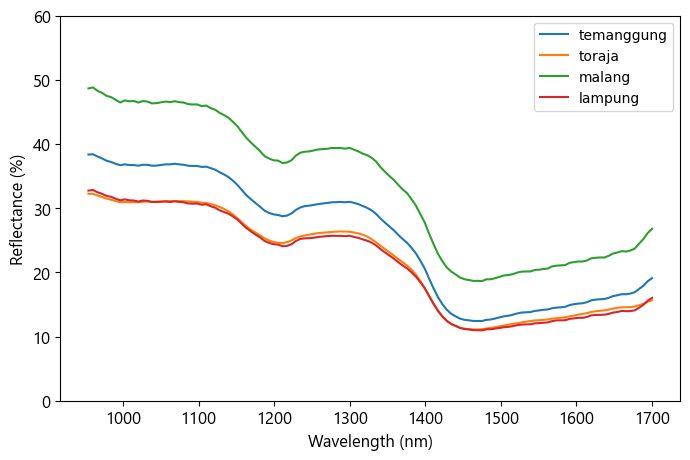

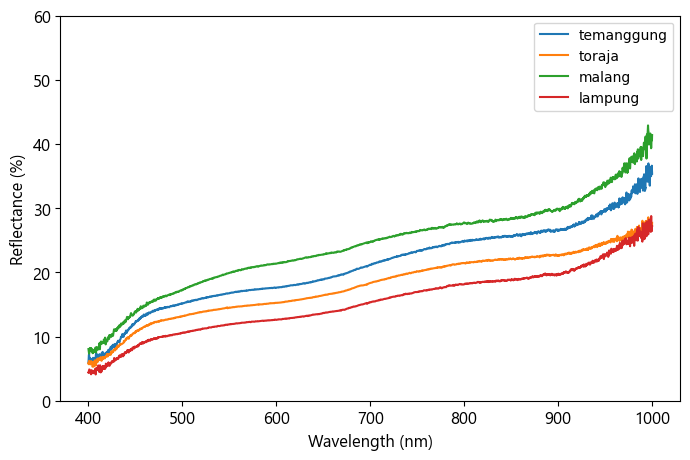

In [47]:
# DETERMINE DATA VARIABLES
label_vis, spectra_vis, wls_vis = variable_data(robusta_vis)  # --------------------- < CHANGE INPUT
label_nir, spectra_nir, wls_nir = variable_data(robusta_nir)
label_name = ['temanggung', 'toraja', 'malang', 'lampung']

_, spectra_rtevis, wls_rtevis = variable_data(rtevis)
_, spectra_rtovis, wls_rtovis = variable_data(rtovis)
_, spectra_rmavis, wls_rmavis = variable_data(rmavis)
_, spectra_rlavis, wls_rlavis = variable_data(rlavis)

_, spectra_rtenir, wls_rtenir = variable_data(rtenir)
_, spectra_rtonir, wls_rtonir = variable_data(rtonir)
_, spectra_rmanir, wls_rmanir = variable_data(rmanir)
_, spectra_rlanir, wls_rlanir = variable_data(rlanir)

# OBTAIN AVERAGE SPECTRA
mean_rtevis = np.mean(spectra_rtevis, axis=0)
mean_rtovis = np.mean(spectra_rtovis, axis=0)
mean_rmavis = np.mean(spectra_rmavis, axis=0)
mean_rlavis = np.mean(spectra_rlavis, axis=0)

mean_rtenir = np.mean(spectra_rtenir, axis=0)
mean_rtonir = np.mean(spectra_rtonir, axis=0)
mean_rmanir = np.mean(spectra_rmanir, axis=0)
mean_rlanir = np.mean(spectra_rlanir, axis=0)

# PLOT AVERAGE SPECTRA
plot_average_spectra(wls_rtonir, mean_rtenir, mean_rtonir, mean_rmanir, mean_rlanir, label_name)
plot_average_spectra(wls_rtevis, mean_rtevis, mean_rtovis, mean_rmavis, mean_rlavis, label_name)


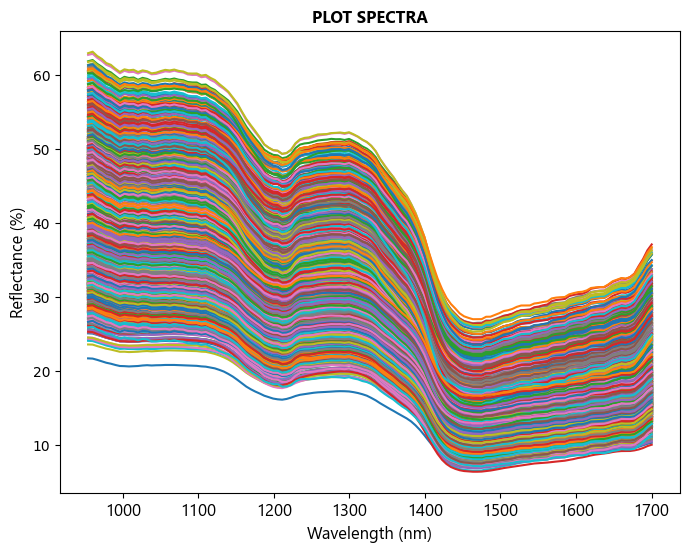

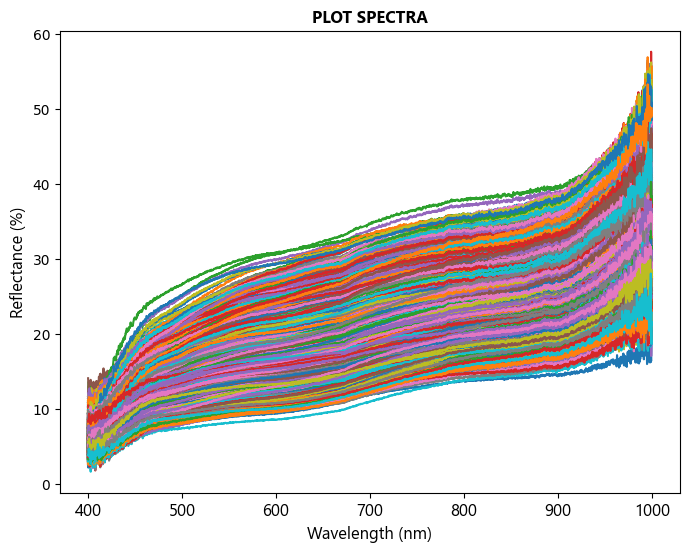

In [48]:
# RUN PLOT SPECTRA
plot_spectra(wls_nir, spectra_nir)      # ------------------------------------ < CHANGE INPUT
plot_spectra(wls_vis, spectra_vis)      # ------------------------------------ < CHANGE INPUT

vis_sma, vis_sgs, vis_msc, vis_snv, vis_sgd1, vis_sgd2 = preprocessing(spectra_vis, wls_vis, 50, 2)
nir_sma, nir_sgs, nir_msc, nir_snv, nir_sgd1, nir_sgd2 = preprocessing(spectra_nir, wls_nir, 5, 2)

In [49]:
# DETERMINE PCA VARIABLES
#PCA_score_vis_ori = pca(spectra_vis, wls_vis, label_vis, 4)
#PCA_score_vis_sma = pca(vis_sma, wls_vis, label_vis, 4)
#PCA_score_vis_sgs = pca(vis_sgs, wls_vis, label_vis, 4)
#PCA_score_vis_msc = pca(vis_msc, wls_vis, label_vis, 4)
#PCA_score_vis_snv = pca(vis_snv, wls_vis, label_vis, 4)
#PCA_score_vis_sgd1 = pca(vis_sgd1, wls_vis, label_vis, 4)
#PCA_score_vis_sgd2 = pca(vis_sgd2, wls_vis, label_vis, 4)

#PCA_score_nir_ori = pca(spectra_nir, wls_nir, label_nir, 4)
#PCA_score_nir_sma = pca(nir_sma, wls_nir, label_nir, 4)
#PCA_score_nir_sgs = pca(nir_sgs, wls_nir, label_nir, 4)
#PCA_score_nir_msc = pca(nir_msc, wls_nir, label_nir, 4)
#PCA_score_nir_snv = pca(nir_snv, wls_nir, label_nir, 4)
#PCA_score_nir_sgd1 = pca(nir_sgd1, wls_nir, label_nir, 4)
#PCA_score_nir_sgd2 = pca(nir_sgd2, wls_nir, label_nir, 4)

#pca_expl_var_nir_ori, pca_expl_var_nir_sma = pca_scree_plot(7, spectra_nir, nir_sma, 0, 7, 0, 1.1)


In [50]:
# DETERMINE PCA EXPLAINED VARIANCE
#pca_eigval_vis_ori, pca_expl_var_vis_ori = pca_scree(10, spectra_vis)
#pca_eigval_vis_sma, pca_expl_var_vis_sma = pca_scree(10, vis_sma)
#pca_eigval_vis_sgs, pca_expl_var_vis_sgs = pca_scree(10, vis_sgs)
#pca_eigval_vis_snv, pca_expl_var_vis_snv = pca_scree(10, vis_snv)
#pca_eigval_vis_msc, pca_expl_var_vis_msc = pca_scree(10, vis_msc)
#pca_eigval_vis_sgd1, pca_expl_var_vis_sgd1 = pca_scree(10, vis_sgd1)
#pca_eigval_vis_sgd2, pca_expl_var_vis_sgd2 = pca_scree(10, vis_sgd2)

#pca_eigval_nir_ori, pca_expl_var_nir_ori = pca_scree(10, spectra_nir)
#pca_eigval_nir_sma, pca_expl_var_nir_sma = pca_scree(10, nir_sma)
#pca_eigval_nir_sgs, pca_expl_var_nir_sgs = pca_scree(10, nir_sgs)
#pca_eigval_nir_snv, pca_expl_var_nir_snv = pca_scree(10, nir_snv)
#pca_eigval_nir_msc, pca_expl_var_nir_msc = pca_scree(10, nir_msc)
#pca_eigval_nir_sgd1, pca_expl_var_nir_sgd1 = pca_scree(10, nir_sgd1)
#pca_eigval_nir_sgd2, pca_expl_var_nir_sgd2 = pca_scree(10, nir_sgd2)

#pca_score_ori_vis, pca_loading_ori_vis = pca_score_plot(spectra_vis, wls_vis, 7, pca_expl_var_vis_ori, label_vis)
#pca_score_sma_vis, pca_loading_sma_vis = pca_score_plot(vis_sma, wls_vis, 7, pca_expl_var_vis_sma, label_vis)
#pca_score_sgs_vis, pca_loading_sgs_vis = pca_score_plot(vis_sgs, wls_vis, 7, pca_expl_var_vis_sgs, label_vis)
#pca_score_sgd1_vis, pca_loading_sgd1_vis = pca_score_plot(vis_sgd1, wls_vis, 7, pca_expl_var_vis_sgd, label_vis)
#pca_score_snv_vis, pca_loading_snv_vis = pca_score_plot(vis_snv, wls_vis, 7, pca_expl_var_vis_snv, label_vis)
#pca_score_msc_vis, pca_loading_msc_vis = pca_score_plot(vis_msc, wls_vis, 7, pca_expl_var_vis_msc, label_vis)

#pca_score_ori_nir, pca_loading_ori_nir = pca_score_plot(spectra_nir, wls_nir, 7, pca_expl_var_nir_ori, label_nir)
#pca_score_sma_nir, pca_loading_sma_nir = pca_score_plot(nir_sma, wls_nir, 7, pca_expl_var_nir_sma, label_nir)
#pca_score_sgs_nir, pca_loading_sgs_nir = pca_score_plot(nir_sgs, wls_nir, 7, pca_expl_var_nir_sgs, label_nir)
#pca_score_sgd1_nir, pca_loading_sgd1_nir = pca_score_plot(nir_sgd1, wls_nir, 7, pca_expl_var_nir_sgd, label_nir)
#pca_score_snv_nir, pca_loading_snv_nir = pca_score_plot(nir_snv, wls_nir, 7, pca_expl_var_nir_snv, label_nir)
#pca_score_msc_nir, pca_loading_msc_nir = pca_score_plot(nir_msc, wls_nir, 7, pca_expl_var_nir_msc, label_nir)

pca_score_ori_vis= pca_scores(spectra_vis, 4)
pca_score_sma_vis = pca_scores(vis_sma,  4)
pca_score_sgs_vis = pca_scores(vis_sgs, 4)
pca_score_msc_vis = pca_scores(vis_msc,  7)
pca_score_sgd1_vis = pca_scores(vis_sgd1, 7)

pca_score_ori_nir = pca_scores(spectra_nir, 3)
pca_score_sma_nir = pca_scores(nir_sma, 3)
pca_score_sgs_nir = pca_scores(nir_sgs, 3)
pca_score_msc_nir = pca_scores(nir_msc, 7)
pca_score_sgd1_nir = pca_scores(nir_sgd1, 7)

In [13]:
# DETERMINE PLS EXPLAINED VARIANCE

#pls_expl_var_nir_ori, pls_expl_var_nir_sma = pls_scree(7, spectra_nir, nir_sma, label_nir, 0, 7, 0, 1.1)
#pls_expl_var_nir_sgs, pls_expl_var_nir_sgd = pls_scree(7, nir_sgs, nir_sgd1, label_nir, 0, 7, 0, 1.1)
#pls_expl_var_nir_snv, pls_expl_var_nir_msc = pls_scree(7, nir_snv, nir_msc, label_nir, 0, 7, 0, 1.1)

#pls_expl_var_vis_ori, pls_expl_var_vis_sma = pls_scree(7, spectra_vis, vis_sma, label_vis, 0, 7, 0, 1.1)
#pls_expl_var_vis_sgs, pls_expl_var_vis_sgd = pls_scree(7, vis_sgs, vis_sgd1, label_vis, 0, 7, 0, 1.1)
#pls_expl_var_vis_snv, pls_expl_var_vis_msc = pls_scree(7, vis_snv, vis_msc, label_vis, 0, 7, 0, 1.1)

In [45]:
# PLS SCORE PLOT

pls_score_ori_vis = pls_score(spectra_vis, label_vis, 4)
pls_score_sma_vis = pls_score(vis_sma, label_vis, 4)
pls_score_sgs_vis = pls_score(vis_sgs, label_vis, 4)
pls_score_msc_vis = pls_score(vis_msc, label_vis, 6)
pls_score_sgd1_vis = pls_score(vis_sgd1, label_vis, 7)

pls_score_ori_nir = pls_score(spectra_nir, label_nir, 3)
pls_score_sma_nir = pls_score(nir_sma, label_nir, 3)
pls_score_sgs_nir = pls_score(nir_sgs, label_nir, 3)
pls_score_msc_nir = pls_score(nir_msc, label_nir, 7)
pls_score_sgd1_nir = pls_score(nir_sgd1, label_nir, 7)

#pls_score_ori_vis, pls_loading_ori_vis = pls_score_plot(spectra_vis, 7, label_vis, wls_vis, pls_expl_var_vis_ori)
#pls_score_sma_vis, pls_loading_sma_vis = pls_score_plot(vis_sma, 7, label_vis, wls_vis, pls_expl_var_vis_sma)
#pls_score_sgs_vis, pls_loading_sgs_vis = pls_score_plot(vis_sgs, 7, label_vis, wls_vis, pls_expl_var_vis_sgs)
#pls_score_sgd1_vis, pls_loading_sgd1_vis = pls_score_plot(vis_sgd1, 7, label_vis, wls_vis, pls_expl_var_vis_sgd)
#pls_score_snv_vis, pls_loading_snv_vis = pls_score_plot(vis_snv, 7, label_vis, wls_vis, pls_expl_var_vis_snv)
#pls_score_msc_vis, pls_loading_msc_vis = pls_score_plot(vis_msc, 7, label_vis, wls_vis, pls_expl_var_vis_msc)

#pls_score_ori_nir, pls_loading_ori_nir = pls_score_plot(spectra_nir, 7, label_nir, wls_nir, pls_expl_var_nir_ori)
#pls_score_sma_nir, pls_loading_sma_nir = pls_score_plot(nir_sma, 7, label_nir, wls_nir, pls_expl_var_nir_sma)
#pls_score_sgs_nir, pls_loading_sgs_nir = pls_score_plot(nir_sgs, 7, label_nir, wls_nir, pls_expl_var_nir_sgs)
#pls_score_sgd1_nir, pls_loading_sgd1_nir = pls_score_plot(nir_sgd1, 7, label_nir, wls_nir, pls_expl_var_nir_sgd)
#pls_score_snv_nir, pls_loading_snv_nir = pls_score_plot(nir_snv, 7, label_nir, wls_nir, pls_expl_var_nir_snv)
#pls_score_msc_nir, pls_loading_msc_nir = pls_score_plot(nir_msc, 7, label_nir, wls_nir, pls_expl_var_nir_msc)


In [15]:

#lda_pca_expl_var_vis_ori, lda_pca_expl_var_vis_sma = lda_scree(3, pca_score_ori_vis, pca_score_sma_vis, label_vis, 0, 5, 0, 1.1)
#lda_pca_expl_var_vis_sgs, lda_pca_expl_var_vis_sgd = lda_scree(3, pca_score_sgs_vis, pca_score_sgd1_vis, label_vis, 0, 5, 0, 1.1)
#lda_pca_expl_var_vis_snv, lda_pca_expl_var_vis_msc = lda_scree(3, pca_score_snv_vis, pca_score_msc_vis, label_vis, 0, 5, 0, 1.1)

#lda_pca_expl_var_nir_ori, lda_pca_expl_var_nir_sma = lda_scree(3, pca_score_ori_nir, pca_score_sma_nir, label_nir, 0, 5, 0, 1.1)
#lda_pca_expl_var_nir_sgs, lda_pca_expl_var_nir_sgd = lda_scree(3, pca_score_sgs_nir, pca_score_sgd1_nir, label_nir, 0, 5, 0, 1.1)
#lda_pca_expl_var_nir_snv, lda_pca_expl_var_nir_msc = lda_scree(3, pca_score_snv_nir, pca_score_msc_nir, label_nir, 0, 5, 0, 1.1)

#lda_pls_expl_var_vis_ori, lda_pls_expl_var_vis_sma = lda_scree(3, pls_score_ori_vis, pca_score_sma_vis, label_vis, 0, 5, 0, 1.1)
#lda_pls_expl_var_vis_sgs, lda_pls_expl_var_vis_sgd = lda_scree(3, pca_score_sgs_vis, pca_score_sgd1_vis, label_vis, 0, 5, 0, 1.1)
#lda_pls_expl_var_vis_snv, lda_pls_expl_var_vis_msc = lda_scree(3, pca_score_snv_vis, pca_score_msc_vis, label_vis, 0, 5, 0, 1.1)

#lda_pls_expl_var_nir_ori, lda_pls_expl_var_nir_sma = lda_scree(3, pca_score_ori_nir, pca_score_sma_nir, label_nir, 0, 5, 0, 1.1)
#lda_pls_expl_var_nir_sgs, lda_pls_expl_var_nir_sgd = lda_scree(3, pca_score_sgs_nir, pca_score_sgd1_nir, label_nir, 0, 5, 0, 1.1)
#lda_pls_expl_var_nir_snv, lda_pls_expl_var_nir_msc = lda_scree(3, pca_score_snv_nir, pca_score_msc_nir, label_nir, 0, 5, 0, 1.1)

In [20]:

#lda_pca_vis_ori = lda_score_plot(pca_score_ori_vis, 3, label_vis, wls_vis, lda_pca_expl_var_vis_ori)
#lda_pca_vis_sma = lda_score_plot(pca_score_sma_vis, 3, label_vis, wls_vis, lda_pca_expl_var_vis_sma)
#lda_pca_vis_sgs = lda_score_plot(pca_score_sgs_vis, 3, label_vis, wls_vis, lda_pca_expl_var_vis_sgs)
#lda_pca_vis_sgd1 = lda_score_plot(pca_score_sgd1_vis, 3, label_vis, wls_vis, lda_pca_expl_var_vis_sgd)
#lda_pca_vis_snv = lda_score_plot(pca_score_snv_vis, 3, label_vis, wls_vis, lda_pca_expl_var_vis_snv)
#lda_pca_vis_msc = lda_score_plot(pca_score_msc_vis, 3, label_vis, wls_vis, lda_pca_expl_var_vis_msc)

#lda_pca_nir_ori = lda_score_plot(pca_score_ori_nir, 3, label_nir, wls_nir, lda_pca_expl_var_nir_ori)
#lda_pca_nir_sma = lda_score_plot(pca_score_sma_nir, 3, label_nir, wls_nir, lda_pca_expl_var_nir_sma)
#lda_pca_nir_sgs = lda_score_plot(pca_score_sgs_nir, 3, label_nir, wls_nir, lda_pca_expl_var_nir_sgs)
#lda_pca_nir_sgd1 = lda_score_plot(pca_score_sgd1_nir, 3, label_nir, wls_nir, lda_pca_expl_var_nir_sgd)
#lda_pca_nir_snv = lda_score_plot(pca_score_snv_nir, 3, label_nir, wls_nir, lda_pca_expl_var_nir_snv)
#lda_pca_nir_msc = lda_score_plot(pca_score_msc_nir, 3, label_nir, wls_nir, lda_pca_expl_var_nir_msc)

#lda_pls_vis_ori = lda_score_plot(pls_score_ori_vis, 3, label_vis, wls_vis, lda_pls_expl_var_vis_ori)
#lda_pls_vis_sma = lda_score_plot(pls_score_sma_vis, 3, label_vis, wls_vis, lda_pls_expl_var_vis_sma)
#lda_pls_vis_sgs = lda_score_plot(pls_score_sgs_vis, 3, label_vis, wls_vis, lda_pls_expl_var_vis_sgs)
#lda_pls_vis_sgd1 = lda_score_plot(pls_score_sgd1_vis, 3, label_vis, wls_vis, lda_pls_expl_var_vis_sgd)
#lda_pls_vis_snv = lda_score_plot(pls_score_snv_vis, 3, label_vis, wls_vis, lda_pls_expl_var_vis_snv)
#lda_pls_vis_msc = lda_score_plot(pls_score_msc_vis, 3, label_vis, wls_vis, lda_pls_expl_var_vis_msc)

#lda_pls_nir_ori = lda_score_plot(pls_score_ori_nir, 3, label_nir, wls_nir, lda_pls_expl_var_nir_ori)
#lda_pls_nir_sma = lda_score_plot(pls_score_sma_nir, 3, label_nir, wls_nir, lda_pls_expl_var_nir_sma)
#lda_pls_nir_sgs = lda_score_plot(pls_score_sgs_nir, 3, label_nir, wls_nir, lda_pls_expl_var_nir_sgs)
#lda_pls_nir_sgd1 = lda_score_plot(pls_score_sgd1_nir, 3, label_nir, wls_nir, lda_pls_expl_var_nir_sgd)
#lda_pls_nir_snv = lda_score_plot(pls_score_snv_nir, 3, label_nir, wls_nir, lda_pls_expl_var_nir_snv)
#lda_pls_nir_msc = lda_score_plot(pls_score_msc_nir, 3, label_nir, wls_nir, lda_pls_expl_var_nir_msc)

#lda_pca_vis_ori = lda_score(pca_score_ori_vis, label_vis, 3)
#lda_pca_vis_sma = lda_score(pca_score_sma_vis, label_vis, 3)
#lda_pca_vis_sgs = lda_score(pca_score_sgs_vis, label_vis, 3)
#lda_pca_vis_sgd1 = lda_score(pca_score_sgd1_vis, label_vis, 3)
#lda_pca_vis_msc = lda_score(pca_score_msc_vis, label_vis, 3)

#lda_pca_nir_ori = lda_score(pca_score_ori_nir, label_nir, 3)
#lda_pca_nir_sma = lda_score(pca_score_sma_nir, label_nir, 3)
#lda_pca_nir_sgs = lda_score(pca_score_sgs_nir, label_nir, 3)
#lda_pca_nir_sgd1 = lda_score(pca_score_sgd1_nir, label_nir, 3)
#lda_pca_nir_msc = lda_score(pca_score_msc_nir, label_nir, 3)

#lda_pls_vis_ori = lda_score(pls_score_ori_vis, label_vis, 3)
#lda_pls_vis_sma = lda_score(pls_score_sma_vis, label_vis, 3)
#lda_pls_vis_sgs = lda_score(pls_score_sgs_vis, label_vis, 3)
#lda_pls_vis_sgd1 = lda_score(pls_score_sgd1_vis, label_vis, 3)
#lda_pls_vis_msc = lda_score(pls_score_msc_vis, label_vis, 3)

#lda_pls_nir_ori = lda_score(pls_score_ori_nir, label_nir, 3)
#lda_pls_nir_sma = lda_score(pls_score_sma_nir, label_nir, 3)
#lda_pls_nir_sgs = lda_score(pls_score_sgs_nir, label_nir, 3)
#lda_pls_nir_sgd1 = lda_score(pls_score_sgd1_nir, label_nir, 3)
#lda_pls_nir_msc = lda_score(pls_score_msc_nir, label_nir, 3)

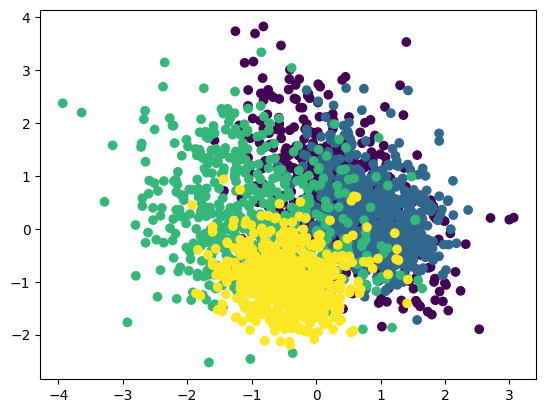

In [51]:
def lda(X, y, n_components, Y=None):
    n_features = np.shape(X)[1]
    labels = np.unique(y)

    """Calculate covariance matrix"""
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    #covariance_matrix = (1/(n_samples-1))*(X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))
    cov_mat = np.array(covariance_matrix, dtype=float)

    """Within Class Scatter Matrix"""
    SW = np.empty((n_features, n_features))
    for label in labels:
        _X = X[y == label]
        SW += (len(_X)-1) * cov_mat

    """Between Class Matrix"""
    total_mean = np.mean(X, axis=0)
    SB = np.empty((n_features, n_features))
    for label in labels:
        _X = X[y == label]
        _mean = np.mean(_X, axis=0)
        SB += len(_X) * (_mean - total_mean).dot((_mean - total_mean).T)

    """TRANSFORM"""
    # Determine SW^-1 * SB by calculating inverse of SW
    A = np.linalg.inv(SW).dot(SB)

    # Get eigenvalues and eigenvectors of SW^-1 * SB
    eigenvalues, eigenvectors = np.linalg.eigh(A)

    # Sort the eigenvalues and corresponding eigenvectors from largest to smallest eigenvalue and select the first n_components
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx][:n_components]
    eigenvectors = eigenvectors[:, idx][:, :n_components]

    # Project the data onto eigenvectors
    X_transformed = X.dot(eigenvectors)

    """ PLOT the dataset X and the corresponding labels y in 2D using the LDA transformation."""
    X1 = X_transformed[:,0]
    X2 = X_transformed[:,1]
    plt.scatter(X1, X2, c=y)
    plt.show()

    return SB, SW, eigenvalues, eigenvectors, X_transformed
SB, SW, eigenvalues, eigenvectors, X_transformed = lda(pca_score_ori_nir, label_nir, 10)


In [53]:
# BUILDING NEURAL NETWORK
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras import callbacks
from sklearn.model_selection import train_test_split, KFold

def ann(X, Y, num_x, num_h, num_H):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
    seed = 7
    np.random.seed(seed)
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    # https://www.kaggle.com/code/danielferrazcampos/neural-network-cross-validation-and-visualization

    print(Y)
    for train, test in kfold.split(X_train, y_train):
        # --- Neural network
        model = Sequential()
        # --- Input dan 1st Hidden Layer
        model.add(Dense(num_h,
                        input_dim=num_x,
                        kernel_initializer='uniform',
                        activation='relu'
                        ))
        # --- 2nd Hidden Layer
        model.add(Dense(num_H, kernel_initializer='uniform', activation='relu'))     # kernel_initializer='uniform',
        # --- Output Layer
        model.add(Dense(4, kernel_initializer='uniform', activation='softmax'))     #softmax untuk banyak kelas

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        # The important arguments : loss, optimizer, metrics
        # https://www.tutorialspoint.com/keras/keras_model_compilation.htm

        earlystopping = callbacks.EarlyStopping(monitor='val_loss',     # val_loss or val_accuracy
                                                min_delta=0,
                                                patience=5,             # the number of epochs for the training to be continued after the first halt
                                                verbose=0,
                                                mode='min',             # min for val_loss, max for val_accuracy, and auto for automatically monitors with the suitable mode.
                                                baseline=None,
                                                restore_best_weights=True)
        # callbacks and num epochs : https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/

        history = model.fit(X_train[train],
                            y_train[train],
                            epochs=100,
                            batch_size=100,
                            validation_data=(X_train[test],y_train[test]),
                            callbacks=[earlystopping],
                            verbose=1)
        # batch_size vs iterations vs epochs = https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

        # evaluate the model
        scores = model.evaluate(X_train[test], y_train[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

    #y_pred_cal = model.predict(X[train])
    #y_pred_val = model.predict(X[test])
    y_pred_cal = model.predict(X_train)
    y_pred_val = model.predict(X_test)

    # --- Converting predictions to label
    pred_cal = list()
    for i in range(len(y_pred_cal)):
        pred_cal.append(np.argmax(y_pred_cal[i]))
    pred_val = list()
    for i in range(len(y_pred_val)):
        pred_val.append(np.argmax(y_pred_val[i]))

    # --- Converting one hot encoded test label to label
    test_cal = list()
    for i in range(len(y_train)):
        test_cal.append(np.argmax(y_train[i]))
    test_val = list()
    for i in range(len(y_test)):
        test_val.append(np.argmax(y_test[i]))

    # MODEL's PERFORMANCE
    a = accuracy_score(pred_cal,test_cal)
    print('The accuracy of training data is:', a*100)
    b = accuracy_score(pred_val,test_val)
    print('The accuracy of testing data is:', b*100)

    # --- Confusion Matrix
    cm_cal = confusion_matrix(pred_cal, test_cal)
    print(cm_cal)
    cm_val = confusion_matrix(pred_val, test_val)
    print(cm_val)

    display1 = ConfusionMatrixDisplay(cm_cal,display_labels=["TEMANGGUNG", "TORAJA", "GAYO", "KINTAMANI"])
    display1.plot()
    display1.figure_.suptitle("Confusion Matrix of Training Data")
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.show()

    display2 = ConfusionMatrixDisplay(cm_val,display_labels=["TEMANGGUNG", "TORAJA", "GAYO", "KINTAMANI"])
    display2.plot()
    display2.figure_.suptitle("Confusion Matrix of Testing Data")
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.show()

    # --- Performace Metrics
    res1 = classification_report(pred_cal, test_cal)
    print(res1)
    res2 = classification_report(pred_val, test_val)
    print(res2)
    # https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(history.history['accuracy'], linewidth=2.0, color='g')
    plt.plot(history.history['val_accuracy'], linewidth=2.0, color='r')
    #plt.title('Model Accuracy', fontsize = 12, fontname="Segoe UI", fontweight='bold')
    plt.ylabel('Accuracy', fontname="Segoe UI", fontsize=12)
    plt.xlabel('Epoch', fontname="Segoe UI", fontsize=12)
    plt.legend(['Training Accuracy ', 'Testing Accuracy'], loc='lower right', fontsize=10)
    plt.grid(False)
    plt.show()

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(history.history['loss'], linewidth=2.0)
    plt.plot(history.history['val_loss'], linewidth=2.0)
    #plt.title('Model Loss', fontname="Segoe UI", fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontname="Segoe UI", fontsize=12)
    plt.xlabel('Epoch', fontname="Segoe UI", fontsize=12)
    plt.legend(['Training Loss', 'Testing Loss'], loc='upper right', fontsize=10)
    plt.grid(False)
    plt.show()

    # ROC-AUC curve
    from scipy import interpolate
    from sklearn.metrics import roc_curve, auc

    n_classes = 4
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train[:, i], y_pred_cal[:, i], )
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(fpr[0], tpr[0], color = 'darkorange', lw = 1, label = 'Temanggung (AUC = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color = 'navy', lw = 1, label = 'Toraja (AUC = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2], color = 'deeppink', lw = 1, label = 'Dampit (AUC = %0.2f)' % roc_auc[2])
    plt.plot(fpr[3], tpr[3], color = 'green', lw = 1, label = 'Lampung (AUC = %0.2f)' % roc_auc[3])
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.show()

    # https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

    # https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(label_nir)
encoded_Y = encoder.transform(label_nir)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

#ann(lda_pls_nir_ori, dummy_y, 3, 6, 6)